# Constrained Training

This file contains code for constrained training with mask loss

Initialisation code

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import initializers
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from tensorflow.keras.models import load_model
import tensorflow as tf
import time
import keras
from math import log
print(keras.__version__)
%tensorflow_version 2.x
%matplotlib inline 
from sklearn.utils import shuffle

2.5.0


Run this to turn debug on

In [ ]:
%xmode Plain
%pdb on

Exception reporting mode: Plain
Automatic pdb calling has been turned OFF


Set up MNIST train/test data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32').reshape((x_train.shape[0], 28, 28))
x_test = x_test.astype('float32').reshape((x_test.shape[0], 28, 28))
print('x_train: ', x_train.shape)
# x_train, y_train = shuffle(x_train, y_train)

x_train /= 255
x_test /= 255

num_rows = 28
num_cols = 28
num_channels = 1
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)   

11493376/11490434 [==============================] - 0s 0us/step
x_train:  (60000, 28, 28)


Load a previously trained model if needed

In [ ]:
filename = "constrained_masked_mnist.h5"
model = load_model(filename)
model.summary()
model.evaluate(x_test, y_test)

# Mask Creation

Run this to generate the set of masks

In [ ]:
pixel_count = 4
x_masks = []
n = 60000
for image in range(len(x_train[0:n])):
  print(image, 'of', str(n) + ':', str(image/n*100), '%')
  img = x_train[image]
  copy = img.copy()
  for i in range(pixel_count):
    for x in range(1, 26, 1):
      for y in range(1, 26, 1):
        if img[x][y] != 0:
          copy[x][y] = 1
          copy[x+1][y] = 1
          copy[x-1][y] = 1
          copy[x][y+1] = 1
          copy[x][y-1] = 1
    img = copy.copy()
  x_masks.append(copy)
plt.imshow(x_masks[0])
plt.show()

x_test_masks = []
n = 10000
for image in range(len(x_test[0:n])):
  print(image, 'of', str(n) + ':', str(image/n*100), '%')
  img = x_train[image]
  copy = img.copy()
  for i in range(pixel_count):
    for x in range(1, 26, 1):
      for y in range(1, 26, 1):
        if img[x][y] != 0:
          copy[x][y] = 1
          copy[x+1][y] = 1
          copy[x-1][y] = 1
          copy[x][y+1] = 1
          copy[x][y-1] = 1
    img = copy.copy()
  x_test_masks.append(copy)
plt.imshow(x_test_masks[0])
plt.show()

# one sided mask
# mask = x_train[0].copy()
# for x in range(28):
#   for y in range(28):
#     # if not (x % 3 == 0 and y % 3 == 0):
#     if x > 13:
#       mask[x][y] = 1
#     else:
#       mask[x][y] = 0

# mask = mask.reshape(784,)
# print(mask.shape)
# plt.imshow(mask.reshape(28, 28))
# plt.show()

Run this to add noise to the data

In [ ]:
x_train += np.random.normal(0.15, 0.15, x_train.shape)
x_test += np.random.normal(0.15, 0.15, x_test.shape)

Fc_mnist model code

In [ ]:
# Here we define our model as a sequential neural network
def get_model():
  model = Sequential()
  model.add(Flatten(input_shape=(28, 28)))

  model.add(Dense(512, kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))

  model.add(Dense(512, kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))

  model.add(Dense(256, kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))

  model.add(Dense(256, kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))

  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  return model

def calc_acc(model_name, data, test_set):
  preds = model_name.predict(data)
  score = 0
  for i in range(len(data)):
    pred = preds[i]
    target = test_set[i]
    if np.argmax(pred) == np.argmax(target):
      score += 1

  print("Acc:", score, 'of', len(x_test))
  return score/len(x_test)

model = get_model()
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_6 (Activation)    (None, 256)              

cnn_mnist model code

In [ ]:
# Here we define our model as a sequential neural network
def get_model():
  model = Sequential()
  model.add(Input(shape=(28, 28, 1)))
  model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))

  model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())

  model.add(Dense(512, kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  model.add(Dense(256, kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  model.add(Dense(10,))
  model.add(Activation('softmax'))

  return model

def calc_acc(model_name, data, test_set):
  preds = model_name.predict(data)
  score = 0
  for i in range(len(data)):
    pred = preds[i]
    target = test_set[i]
    if np.argmax(pred) == np.argmax(target):
      score += 1

  print("Acc:", score, 'of', len(x_test))
  return score/len(x_test)

model = get_model()
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001) # not 0.01 - too fast and can nan
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# model.compile(loss=tf.keras.losses.mean_squared_error, optimizer=optimizer, metrics=[tf.keras.metrics.MeanSquaredError()])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation_9 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)              

Small cnn model code

In [ ]:
# small
# Here we define our model as a sequential neural network
def get_model():
  model = Sequential()
  model.add(Input(shape=(28, 28, 1)))
  model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))

  model.add(Conv2D(16, kernel_size=(3, 3), kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())

  model.add(Dense(256, kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  model.add(Dense(128, kernel_initializer='random_uniform',
                      bias_initializer=initializers.Constant(0.1)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))

  model.add(Dense(10,))
  model.add(Activation('softmax'))

  return model

def calc_acc(model_name, data, test_set):
  preds = model_name.predict(data)
  score = 0
  for i in range(len(data)):
    pred = preds[i]
    target = test_set[i]
    if np.argmax(pred) == np.argmax(target):
      score += 1

  print("Acc:", score, 'of', len(x_test))
  return score/len(x_test)

model = get_model()
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001) # not 0.01 - too fast and can nan
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# model.compile(loss=tf.keras.losses.mean_squared_error, optimizer=optimizer, metrics=[tf.keras.metrics.MeanSquaredError()])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_14 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 16)        4624      
_________________________________________________________________
activation_15 (Activation)   (None, 24, 24, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

Run to train normally on the data

In [ ]:
n = 60000
model = get_model()
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(x_train.reshape(60000, 28, 28, 1), y_train, batch_size=32, epochs=10)
calc_acc(model, x_test.reshape(10000, 28, 28, 1), y_test)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_40 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_41 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_42 (Activation)   (None, 256)              

0.9778

# Constrained Training Mask Loss


Training loop for constrained network

This code trains

1.   Calculate prediction loss
2.   Retrieve intermediate neuron activity of target layer
3.   Calculate gradient of target layer w.r.t input
4.   For each neuron compute v from ICD
5.   For each v calculate neuron distraction score according to input mask
6.   Minimise loss as pred + mask_score



Tf Function Version

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_25 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_26 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_27 (Activation)   (None, 256)              

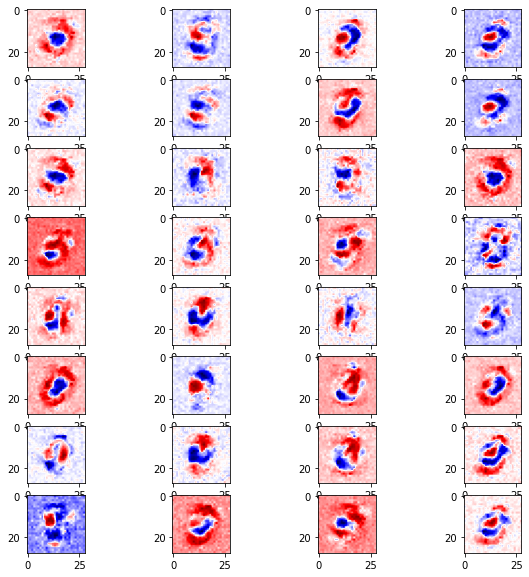

Epoch 0 of 15 Batch 201.0 of 1875.0
Time:  00:02:12 out of estimated: 05:08:50 time remaining: 05:06:37
Mask loss: tf.Tensor(0.2066273, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.7736155, shape=(), dtype=float32)
Acc: 7893 of 10000

Epoch 0 of 15 Batch 202.0 of 1875.0
Time:  00:02:12 out of estimated: 05:08:24 time remaining: 05:06:11
Mask loss: tf.Tensor(0.1142463, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.9511353, shape=(), dtype=float32)
Acc: 7834 of 10000

Epoch 0 of 15 Batch 203.0 of 1875.0
Time:  00:02:13 out of estimated: 05:07:55 time remaining: 05:05:42
Mask loss: tf.Tensor(0.15361099, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.66176367, shape=(), dtype=float32)
Acc: 7672 of 10000

Epoch 0 of 15 Batch 204.0 of 1875.0
Time:  00:02:14 out of estimated: 05:08:09 time remaining: 05:05:55
Mask loss: tf.Tensor(0.13466296, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.6167808, shape=(), dtype=float32)
Acc: 7525 of 10000

Epoch 0 of 15 Batch 205.0 of 1875.0
Time:  00:02:

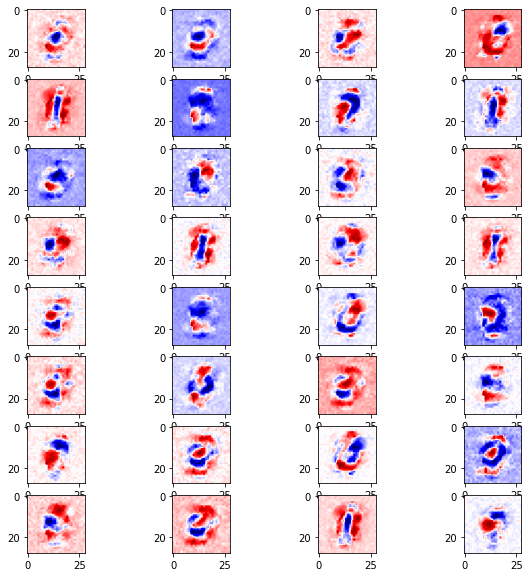

Epoch 0 of 15 Batch 301.0 of 1875.0
Time:  00:03:15 out of estimated: 05:05:08 time remaining: 05:01:52
Mask loss: tf.Tensor(0.072002456, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.47413313, shape=(), dtype=float32)
Acc: 8475 of 10000

Epoch 0 of 15 Batch 302.0 of 1875.0
Time:  00:03:16 out of estimated: 05:04:50 time remaining: 05:01:33
Mask loss: tf.Tensor(0.03631485, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.40665945, shape=(), dtype=float32)
Acc: 8384 of 10000

Epoch 0 of 15 Batch 303.0 of 1875.0
Time:  00:03:17 out of estimated: 05:04:59 time remaining: 05:01:42
Mask loss: tf.Tensor(0.008593033, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.11803983, shape=(), dtype=float32)
Acc: 8276 of 10000

Epoch 0 of 15 Batch 304.0 of 1875.0
Time:  00:03:17 out of estimated: 05:05:07 time remaining: 05:01:50
Mask loss: tf.Tensor(0.08230311, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.62642324, shape=(), dtype=float32)
Acc: 8193 of 10000

Epoch 0 of 15 Batch 305.0 of 1875.0
Time: 

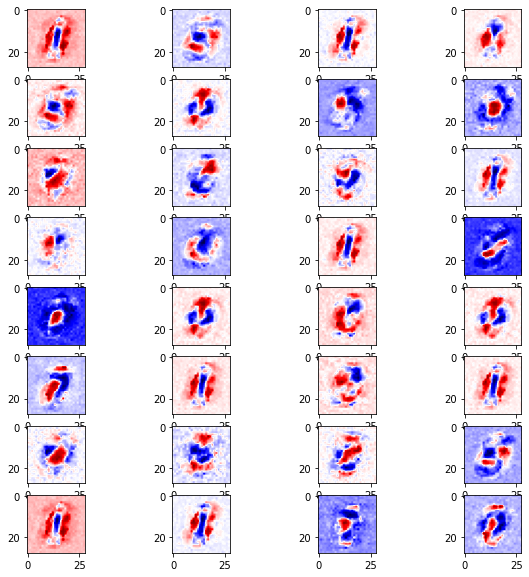

Epoch 0 of 15 Batch 401.0 of 1875.0
Time:  00:04:20 out of estimated: 05:04:54 time remaining: 05:00:33
Mask loss: tf.Tensor(0.06855907, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.5986326, shape=(), dtype=float32)
Acc: 8483 of 10000

Epoch 0 of 15 Batch 402.0 of 1875.0
Time:  00:04:21 out of estimated: 05:04:40 time remaining: 05:00:19
Mask loss: tf.Tensor(0.07372527, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.43870187, shape=(), dtype=float32)
Acc: 8296 of 10000

Epoch 0 of 15 Batch 403.0 of 1875.0
Time:  00:04:22 out of estimated: 05:04:47 time remaining: 05:00:25
Mask loss: tf.Tensor(0.55413115, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.6686119, shape=(), dtype=float32)
Acc: 8121 of 10000

Epoch 0 of 15 Batch 404.0 of 1875.0
Time:  00:04:22 out of estimated: 05:04:34 time remaining: 05:00:11
Mask loss: tf.Tensor(0.2413565, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.7185603, shape=(), dtype=float32)
Acc: 8114 of 10000

Epoch 0 of 15 Batch 405.0 of 1875.0
Time:  00:04

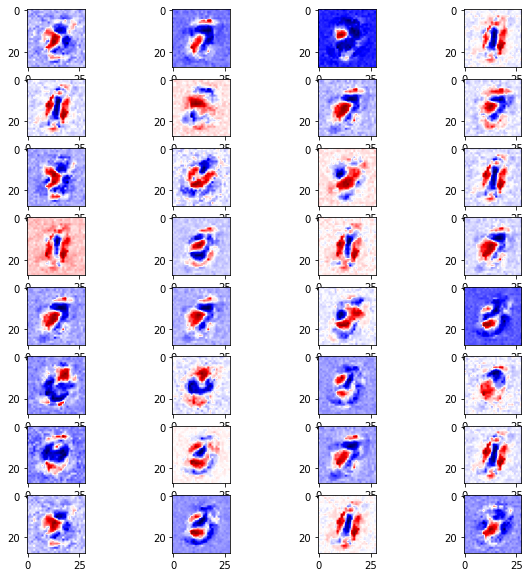

Epoch 0 of 15 Batch 501.0 of 1875.0
Time:  00:05:25 out of estimated: 05:04:41 time remaining: 04:59:15
Mask loss: tf.Tensor(0.09897867, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.9652698, shape=(), dtype=float32)
Acc: 8117 of 10000

Epoch 0 of 15 Batch 502.0 of 1875.0
Time:  00:05:26 out of estimated: 05:04:46 time remaining: 04:59:20
Mask loss: tf.Tensor(0.21808037, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.61086833, shape=(), dtype=float32)
Acc: 8082 of 10000

Epoch 0 of 15 Batch 503.0 of 1875.0
Time:  00:05:27 out of estimated: 05:04:52 time remaining: 04:59:24
Mask loss: tf.Tensor(0.12520562, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.6845797, shape=(), dtype=float32)
Acc: 8070 of 10000

Epoch 0 of 15 Batch 504.0 of 1875.0
Time:  00:05:27 out of estimated: 05:04:57 time remaining: 04:59:29
Mask loss: tf.Tensor(0.121942595, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.52413136, shape=(), dtype=float32)
Acc: 8057 of 10000

Epoch 0 of 15 Batch 505.0 of 1875.0
Time:  00

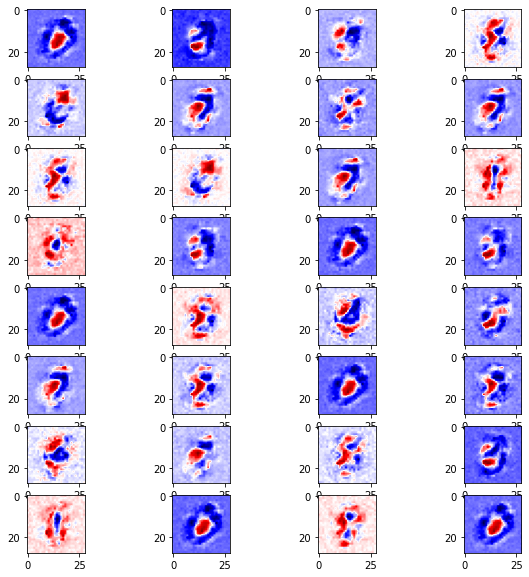

Epoch 0 of 15 Batch 601.0 of 1875.0
Time:  00:06:30 out of estimated: 05:04:51 time remaining: 04:58:20
Mask loss: tf.Tensor(0.2735081, shape=(), dtype=float32)
Acc loss: tf.Tensor(1.0266261, shape=(), dtype=float32)
Acc: 7632 of 10000

Epoch 0 of 15 Batch 602.0 of 1875.0
Time:  00:06:31 out of estimated: 05:04:42 time remaining: 04:58:11
Mask loss: tf.Tensor(0.15511945, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.80687714, shape=(), dtype=float32)
Acc: 7776 of 10000

Epoch 0 of 15 Batch 603.0 of 1875.0
Time:  00:06:32 out of estimated: 05:04:46 time remaining: 04:58:14
Mask loss: tf.Tensor(0.18955608, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.7930043, shape=(), dtype=float32)
Acc: 7913 of 10000

Epoch 0 of 15 Batch 604.0 of 1875.0
Time:  00:06:32 out of estimated: 05:04:38 time remaining: 04:58:05
Mask loss: tf.Tensor(0.69232804, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.69232804, shape=(), dtype=float32)
Acc: 7981 of 10000

Epoch 0 of 15 Batch 605.0 of 1875.0
Time:  00:0

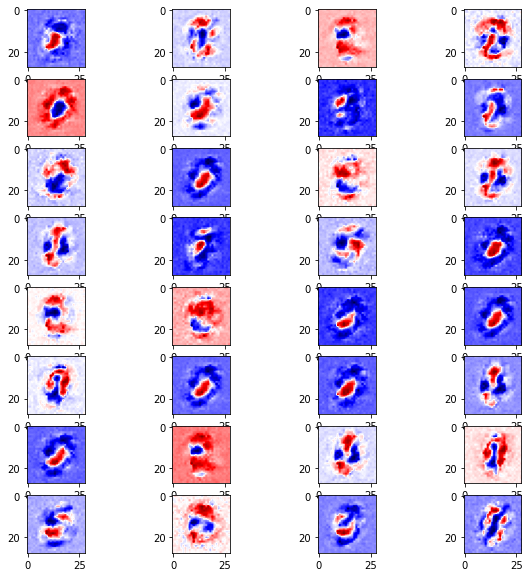

Epoch 0 of 15 Batch 701.0 of 1875.0
Time:  00:07:34 out of estimated: 05:03:56 time remaining: 04:56:22
Mask loss: tf.Tensor(0.14768098, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.5684545, shape=(), dtype=float32)
Acc: 7699 of 10000

Epoch 0 of 15 Batch 702.0 of 1875.0
Time:  00:07:35 out of estimated: 05:04:00 time remaining: 04:56:25
Mask loss: tf.Tensor(0.13245639, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.9761242, shape=(), dtype=float32)
Acc: 7836 of 10000

Epoch 0 of 15 Batch 703.0 of 1875.0
Time:  00:07:36 out of estimated: 05:04:04 time remaining: 04:56:28
Mask loss: tf.Tensor(0.29596844, shape=(), dtype=float32)
Acc loss: tf.Tensor(1.0791764, shape=(), dtype=float32)
Acc: 7972 of 10000

Epoch 0 of 15 Batch 704.0 of 1875.0
Time:  00:07:36 out of estimated: 05:03:56 time remaining: 04:56:19
Mask loss: tf.Tensor(0.11206103, shape=(), dtype=float32)
Acc loss: tf.Tensor(1.1579666, shape=(), dtype=float32)
Acc: 8037 of 10000

Epoch 0 of 15 Batch 705.0 of 1875.0
Time:  00:07

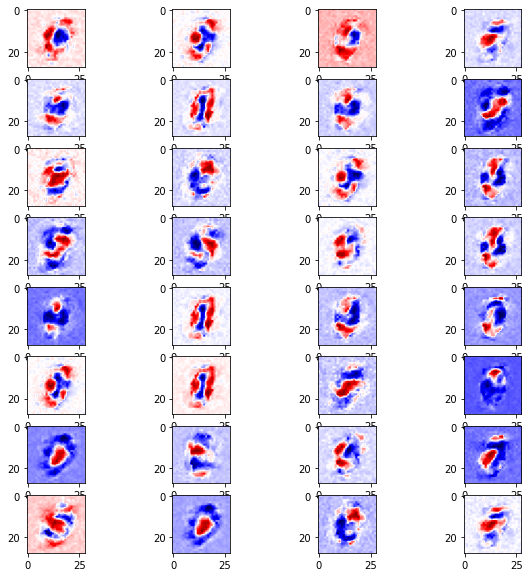

Epoch 0 of 15 Batch 801.0 of 1875.0
Time:  00:08:37 out of estimated: 05:02:55 time remaining: 04:54:18
Mask loss: tf.Tensor(0.09204689, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.42584237, shape=(), dtype=float32)
Acc: 8570 of 10000

Epoch 0 of 15 Batch 802.0 of 1875.0
Time:  00:08:38 out of estimated: 05:02:59 time remaining: 04:54:20
Mask loss: tf.Tensor(0.11618965, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.35922658, shape=(), dtype=float32)
Acc: 8641 of 10000

Epoch 0 of 15 Batch 803.0 of 1875.0
Time:  00:08:39 out of estimated: 05:03:02 time remaining: 04:54:23
Mask loss: tf.Tensor(0.071205094, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.3429655, shape=(), dtype=float32)
Acc: 8662 of 10000

Epoch 0 of 15 Batch 804.0 of 1875.0
Time:  00:08:39 out of estimated: 05:02:56 time remaining: 04:54:17
Mask loss: tf.Tensor(0.21117593, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.47721243, shape=(), dtype=float32)
Acc: 8699 of 10000

Epoch 0 of 15 Batch 805.0 of 1875.0
Time:  0

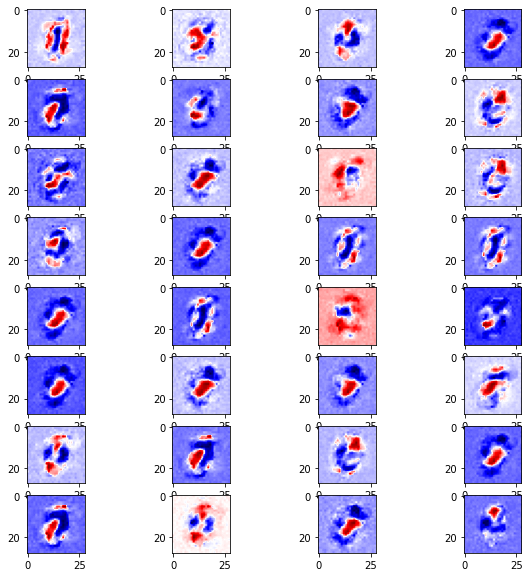

Epoch 0 of 15 Batch 901.0 of 1875.0
Time:  00:09:42 out of estimated: 05:03:01 time remaining: 04:53:19
Mask loss: tf.Tensor(0.23147894, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.55609804, shape=(), dtype=float32)
Acc: 8719 of 10000

Epoch 0 of 15 Batch 902.0 of 1875.0
Time:  00:09:43 out of estimated: 05:03:05 time remaining: 04:53:21
Mask loss: tf.Tensor(0.12493157, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.42714006, shape=(), dtype=float32)
Acc: 8722 of 10000

Epoch 0 of 15 Batch 903.0 of 1875.0
Time:  00:09:43 out of estimated: 05:02:59 time remaining: 04:53:15
Mask loss: tf.Tensor(0.03474008, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.49809095, shape=(), dtype=float32)
Acc: 8703 of 10000

Epoch 0 of 15 Batch 904.0 of 1875.0
Time:  00:09:44 out of estimated: 05:03:02 time remaining: 04:53:18
Mask loss: tf.Tensor(0.12018233, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.7645968, shape=(), dtype=float32)
Acc: 8740 of 10000

Epoch 0 of 15 Batch 905.0 of 1875.0
Time:  00

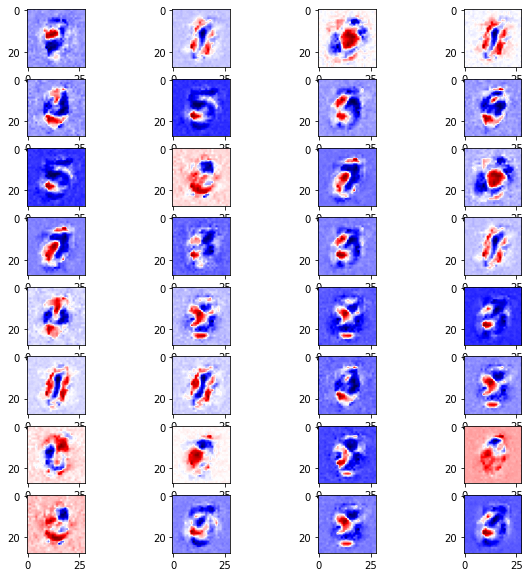

Epoch 0 of 15 Batch 1001.0 of 1875.0
Time:  00:10:46 out of estimated: 05:02:53 time remaining: 04:52:07
Mask loss: tf.Tensor(0.12816988, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.55735147, shape=(), dtype=float32)
Acc: 8922 of 10000

Epoch 0 of 15 Batch 1002.0 of 1875.0
Time:  00:10:47 out of estimated: 05:02:48 time remaining: 04:52:01
Mask loss: tf.Tensor(0.065613806, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.475589, shape=(), dtype=float32)
Acc: 8909 of 10000

Epoch 0 of 15 Batch 1003.0 of 1875.0
Time:  00:10:47 out of estimated: 05:02:43 time remaining: 04:51:55
Mask loss: tf.Tensor(0.06650266, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.5684972, shape=(), dtype=float32)
Acc: 8890 of 10000

Epoch 0 of 15 Batch 1004.0 of 1875.0
Time:  00:10:48 out of estimated: 05:02:46 time remaining: 04:51:57
Mask loss: tf.Tensor(0.3151376, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.48832121, shape=(), dtype=float32)
Acc: 8867 of 10000

Epoch 0 of 15 Batch 1005.0 of 1875.0
Time: 

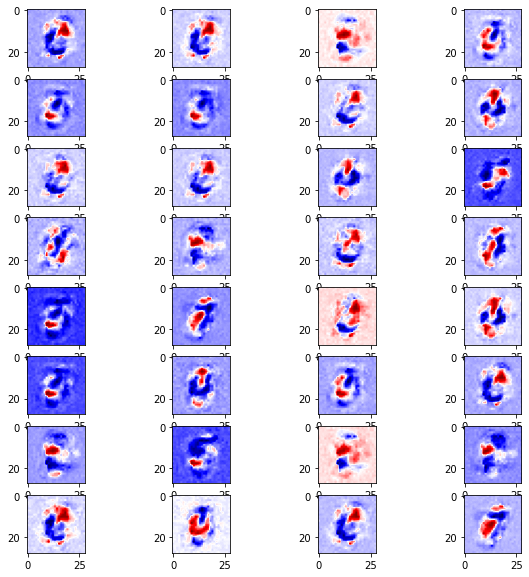

Epoch 0 of 15 Batch 1101.0 of 1875.0
Time:  00:11:52 out of estimated: 05:03:32 time remaining: 04:51:39
Mask loss: tf.Tensor(0.18953392, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.83973145, shape=(), dtype=float32)
Acc: 8212 of 10000

Epoch 0 of 15 Batch 1102.0 of 1875.0
Time:  00:11:53 out of estimated: 05:03:28 time remaining: 04:51:34
Mask loss: tf.Tensor(0.151327, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.62825346, shape=(), dtype=float32)
Acc: 8248 of 10000

Epoch 0 of 15 Batch 1103.0 of 1875.0
Time:  00:11:53 out of estimated: 05:03:23 time remaining: 04:51:29
Mask loss: tf.Tensor(0.10141947, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.63810223, shape=(), dtype=float32)
Acc: 8309 of 10000

Epoch 0 of 15 Batch 1104.0 of 1875.0
Time:  00:11:54 out of estimated: 05:03:26 time remaining: 04:51:31
Mask loss: tf.Tensor(0.32247365, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.410076, shape=(), dtype=float32)
Acc: 8344 of 10000

Epoch 0 of 15 Batch 1105.0 of 1875.0
Time:  

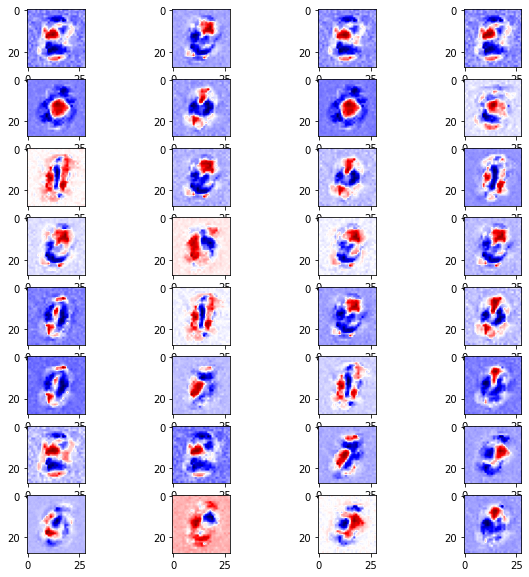

Epoch 0 of 15 Batch 1201.0 of 1875.0
Time:  00:12:58 out of estimated: 05:03:57 time remaining: 04:50:58
Mask loss: tf.Tensor(0.3431731, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.4856177, shape=(), dtype=float32)
Acc: 8308 of 10000

Epoch 0 of 15 Batch 1202.0 of 1875.0
Time:  00:12:59 out of estimated: 05:03:53 time remaining: 04:50:54
Mask loss: tf.Tensor(0.6403886, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.6403886, shape=(), dtype=float32)
Acc: 8217 of 10000

Epoch 0 of 15 Batch 1203.0 of 1875.0
Time:  00:12:59 out of estimated: 05:03:49 time remaining: 04:50:49
Mask loss: tf.Tensor(0.10223032, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.81082493, shape=(), dtype=float32)
Acc: 8171 of 10000

Epoch 0 of 15 Batch 1204.0 of 1875.0
Time:  00:13:00 out of estimated: 05:03:45 time remaining: 04:50:45
Mask loss: tf.Tensor(0.5163477, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.5163477, shape=(), dtype=float32)
Acc: 8102 of 10000

Epoch 0 of 15 Batch 1205.0 of 1875.0
Time:  00

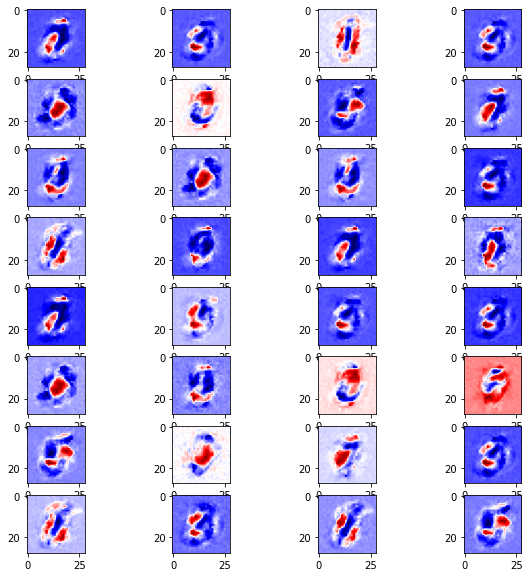

Epoch 0 of 15 Batch 1301.0 of 1875.0
Time:  00:14:02 out of estimated: 05:03:40 time remaining: 04:49:37
Mask loss: tf.Tensor(0.06961029, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.293136, shape=(), dtype=float32)
Acc: 8681 of 10000

Epoch 0 of 15 Batch 1302.0 of 1875.0
Time:  00:14:03 out of estimated: 05:03:42 time remaining: 04:49:39
Mask loss: tf.Tensor(0.07596576, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.24717146, shape=(), dtype=float32)
Acc: 8722 of 10000

Epoch 0 of 15 Batch 1303.0 of 1875.0
Time:  00:14:04 out of estimated: 05:03:39 time remaining: 04:49:35
Mask loss: tf.Tensor(1.4113355, shape=(), dtype=float32)
Acc loss: tf.Tensor(1.4113355, shape=(), dtype=float32)
Acc: 8714 of 10000

Epoch 0 of 15 Batch 1304.0 of 1875.0
Time:  00:14:04 out of estimated: 05:03:35 time remaining: 04:49:31
Mask loss: tf.Tensor(0.045246813, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.650417, shape=(), dtype=float32)
Acc: 8682 of 10000

Epoch 0 of 15 Batch 1305.0 of 1875.0
Time:  0

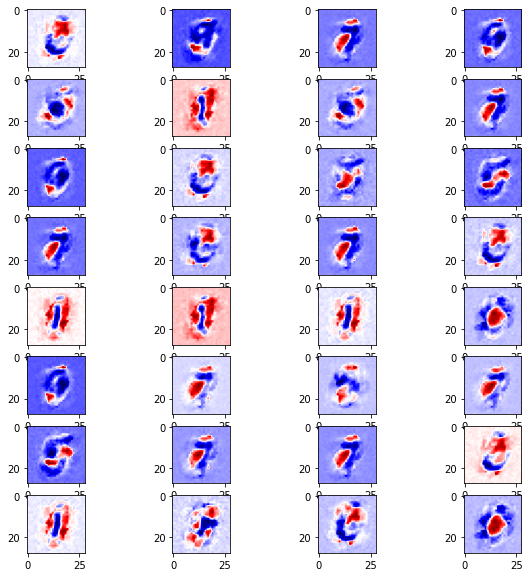

Epoch 0 of 15 Batch 1401.0 of 1875.0
Time:  00:15:08 out of estimated: 05:04:01 time remaining: 04:48:52
Mask loss: tf.Tensor(0.10260581, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.4189751, shape=(), dtype=float32)
Acc: 8906 of 10000

Epoch 0 of 15 Batch 1402.0 of 1875.0
Time:  00:15:09 out of estimated: 05:03:58 time remaining: 04:48:49
Mask loss: tf.Tensor(0.027303306, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.46328652, shape=(), dtype=float32)
Acc: 8778 of 10000

Epoch 0 of 15 Batch 1403.0 of 1875.0
Time:  00:15:09 out of estimated: 05:04:00 time remaining: 04:48:50
Mask loss: tf.Tensor(0.061909016, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.3897537, shape=(), dtype=float32)
Acc: 8719 of 10000

Epoch 0 of 15 Batch 1404.0 of 1875.0
Time:  00:15:10 out of estimated: 05:03:56 time remaining: 04:48:46
Mask loss: tf.Tensor(0.57836896, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.58092177, shape=(), dtype=float32)
Acc: 8852 of 10000

Epoch 0 of 15 Batch 1405.0 of 1875.0
Tim

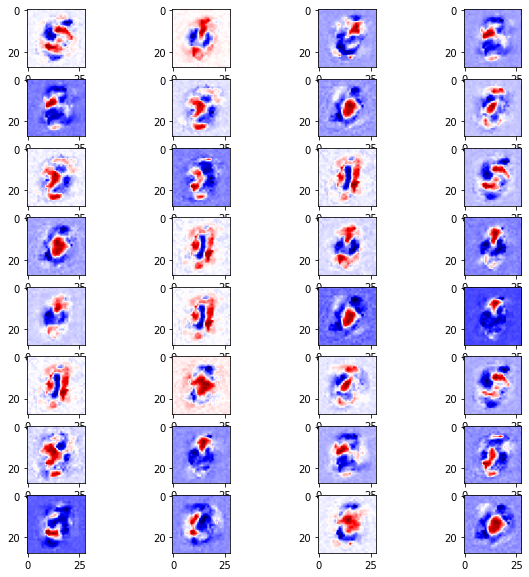

Epoch 0 of 15 Batch 1501.0 of 1875.0
Time:  00:16:15 out of estimated: 05:04:38 time remaining: 04:48:23
Mask loss: tf.Tensor(0.07006641, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.30163723, shape=(), dtype=float32)
Acc: 8799 of 10000

Epoch 0 of 15 Batch 1502.0 of 1875.0
Time:  00:16:16 out of estimated: 05:04:40 time remaining: 04:48:24
Mask loss: tf.Tensor(0.14213058, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.18451339, shape=(), dtype=float32)
Acc: 8456 of 10000

Epoch 0 of 15 Batch 1503.0 of 1875.0
Time:  00:16:17 out of estimated: 05:04:42 time remaining: 04:48:25
Mask loss: tf.Tensor(0.21929277, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.61480945, shape=(), dtype=float32)
Acc: 8319 of 10000

Epoch 0 of 15 Batch 1504.0 of 1875.0
Time:  00:16:17 out of estimated: 05:04:38 time remaining: 04:48:21
Mask loss: tf.Tensor(0.0371021, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.32081705, shape=(), dtype=float32)
Acc: 8258 of 10000

Epoch 0 of 15 Batch 1505.0 of 1875.0
Time

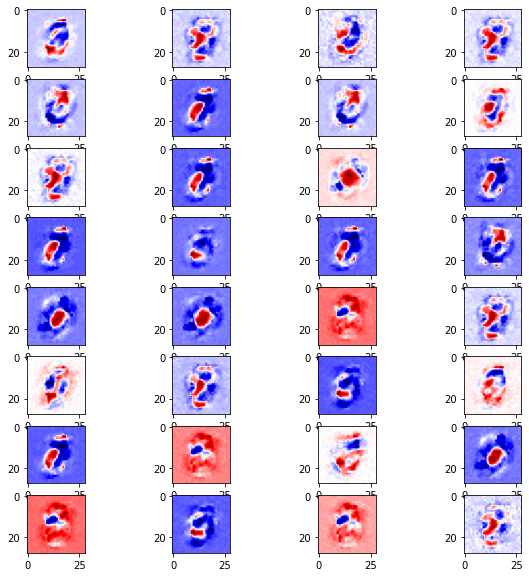

Epoch 0 of 15 Batch 1601.0 of 1875.0
Time:  00:17:20 out of estimated: 05:04:38 time remaining: 04:47:18
Mask loss: tf.Tensor(0.02970632, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.54365087, shape=(), dtype=float32)
Acc: 9053 of 10000

Epoch 0 of 15 Batch 1602.0 of 1875.0
Time:  00:17:21 out of estimated: 05:04:40 time remaining: 04:47:19
Mask loss: tf.Tensor(0.0366186, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.5196198, shape=(), dtype=float32)
Acc: 9052 of 10000

Epoch 0 of 15 Batch 1603.0 of 1875.0
Time:  00:17:21 out of estimated: 05:04:37 time remaining: 04:47:16
Mask loss: tf.Tensor(0.027710555, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.48570597, shape=(), dtype=float32)
Acc: 9049 of 10000

Epoch 0 of 15 Batch 1604.0 of 1875.0
Time:  00:17:22 out of estimated: 05:04:39 time remaining: 04:47:17
Mask loss: tf.Tensor(0.02119336, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.3639813, shape=(), dtype=float32)
Acc: 9041 of 10000

Epoch 0 of 15 Batch 1605.0 of 1875.0
Time:

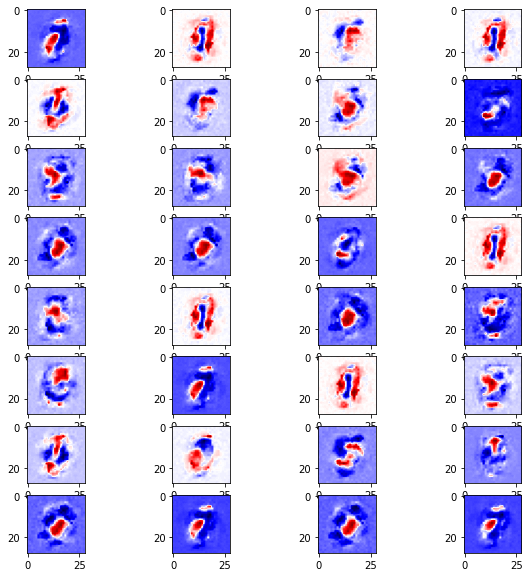

Epoch 0 of 15 Batch 1701.0 of 1875.0
Time:  00:18:29 out of estimated: 05:05:38 time remaining: 04:47:09
Mask loss: tf.Tensor(0.006545869, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.34901273, shape=(), dtype=float32)
Acc: 8891 of 10000

Epoch 0 of 15 Batch 1702.0 of 1875.0
Time:  00:18:29 out of estimated: 05:05:36 time remaining: 04:47:06
Mask loss: tf.Tensor(0.02182912, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.21928047, shape=(), dtype=float32)
Acc: 8926 of 10000

Epoch 0 of 15 Batch 1703.0 of 1875.0
Time:  00:18:30 out of estimated: 05:05:33 time remaining: 04:47:03
Mask loss: tf.Tensor(0.026949935, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.3188413, shape=(), dtype=float32)
Acc: 8946 of 10000

Epoch 0 of 15 Batch 1704.0 of 1875.0
Time:  00:18:30 out of estimated: 05:05:30 time remaining: 04:46:59
Mask loss: tf.Tensor(0.1426978, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.77114844, shape=(), dtype=float32)
Acc: 8964 of 10000

Epoch 0 of 15 Batch 1705.0 of 1875.0
Tim

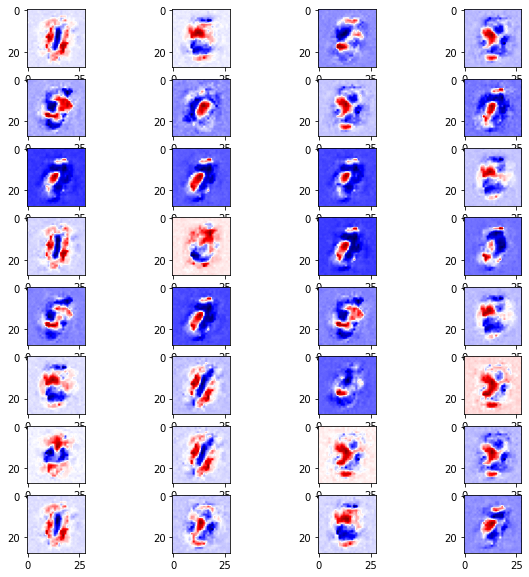

Epoch 0 of 15 Batch 1801.0 of 1875.0
Time:  00:19:34 out of estimated: 05:05:35 time remaining: 04:46:01
Mask loss: tf.Tensor(0.1621896, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.94707084, shape=(), dtype=float32)
Acc: 7975 of 10000

Epoch 0 of 15 Batch 1802.0 of 1875.0
Time:  00:19:34 out of estimated: 05:05:33 time remaining: 04:45:58
Mask loss: tf.Tensor(0.14622478, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.5889977, shape=(), dtype=float32)
Acc: 8318 of 10000

Epoch 0 of 15 Batch 1803.0 of 1875.0
Time:  00:19:35 out of estimated: 05:05:31 time remaining: 04:45:56
Mask loss: tf.Tensor(0.30324957, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.7520904, shape=(), dtype=float32)
Acc: 8654 of 10000

Epoch 0 of 15 Batch 1804.0 of 1875.0
Time:  00:19:35 out of estimated: 05:05:32 time remaining: 04:45:56
Mask loss: tf.Tensor(0.0744074, shape=(), dtype=float32)
Acc loss: tf.Tensor(0.44744825, shape=(), dtype=float32)
Acc: 8745 of 10000

Epoch 0 of 15 Batch 1805.0 of 1875.0
Time:  

KeyboardInterrupt: ignored

In [ ]:
# changed to function to use tf.function to make it faster

model = get_model()
model.summary()
conv = True # whether or not we are using convnet

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_losses = []
neg_losses = []
acc_losses = []
# parameters
# interpretability mask term
alpha = 15.0 # changed to beta in text
alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
target_layer = len(model.layers)-1
n_neurons = model.layers[target_layer].output.shape[-1]
print("Looking at", n_neurons, "neurons in layer", target_layer, model.layers[target_layer].name)
# define a model that lets us get at the internal activations
aux_model = tf.keras.Model(inputs=model.inputs,
                           outputs=[model.layers[target_layer].output[:, i] for i in range(n_neurons)])
start_time = time.time()
# define training step
@tf.function
def step(X, y, batch_size, model, aux_model, target_layer, target_neurons):
  """
  x_batch: input images
  y_batch: correct labels
  batch_size: can be inferred from x_batch
  model: the predicting model to train
  aux_model: the extra model that outputs the target layer of model
  target_layer: which layer to examine
  neuron_mode: target all neurons in the layer or just class neuron (if output layer)
  """
  with tf.GradientTape(persistent=True) as tape:
    # get predictions and calculate acc loss for the batch
    preds = model(X)
    losses = tf.keras.losses.categorical_crossentropy(y, preds)

    # Get internal activations from aux model
    # x = tf.convert_to_tensor(X, dtype=tf.float32)
    if conv:
      x = tf.reshape(X, (batch_size, 28, 28, 1))
    else:
      x = tf.reshape(X, (batch_size, 28, 28))
    with tf.GradientTape(persistent=True) as aux_tape:
      # this is activations at target_layer
      aux_tape.watch(x)
      neuron_activations = aux_model(x)  # eq 1

    # compute gradients w.r.t from neurons in target layer
    # a bit of wasted computation here as all neuron gradients in the layer are
    # calculated even if we don't use them all...
    grad_maps = []
    for neuron in neuron_activations:
      # local grad maps are (28, 28) images to input
      grad_maps.append(aux_tape.gradient(neuron, x))
    grad_maps = tf.reshape(grad_maps, (batch_size, n_neurons, 784))
    x = tf.reshape(x, (batch_size, 784,))
    neuron_activations = tf.reshape(neuron_activations, (batch_size, n_neurons))

    # Caclulate v from neuron-input gradients
    V = []
    W = []
    for batch in range(batch_size):
      batch_v = []
      batch_w = []
      # which output neuron to use
      target_neuron = target_neurons[batch]
      w_hat = tf.reshape(grad_maps[batch][target_neuron], (784,))  # eq 4
      b_hat = tf.math.subtract(neuron_activations[batch][target_neuron], tf.multiply(x[batch], tf.transpose(w_hat)))  # eq 5
      v = tf.math.add(tf.multiply(w_hat, x[batch]), b_hat)  # eq 2
      c_hat = tf.math.subtract(x[batch], tf.tensordot(v / (tf.tensordot(w_hat, tf.transpose(w_hat), axes=1)), w_hat, axes=1))  # CHECK AXES is 1 for both
      v_hat = tf.math.multiply(tf.math.subtract(x[batch], c_hat), w_hat)  # eq 8
      v = tf.transpose(v_hat)
      batch_v.append(v)  # eq 11
      batch_w.append(w_hat)

      # layer code for examining the entire layer instead
      # for neuron in range(n_neurons):
      #   w_hat = tf.reshape(grad_maps[batch][neuron], (784,))  # eq 4
      #   b_hat = tf.math.subtract(neuron_activations[batch][neuron], tf.multiply(x[batch], tf.transpose(w_hat)))  # eq 5
      #   v = tf.math.add(tf.multiply(w_hat, x[batch]), b_hat)  # eq 2
      #   c_hat = tf.math.subtract(x[batch], tf.tensordot(v / (tf.tensordot(w_hat, tf.transpose(w_hat), axes=1)), w_hat, axes=1))  # CHECK AXES is 1 for both
      #   v_hat = tf.math.multiply(tf.math.subtract(x[batch], c_hat), w_hat)  # eq 8
      #   v = tf.transpose(v_hat)
      #   batch_v.append(v)  # eq 11
      V.append(batch_v)
      W.append(batch_w)

    # calculate mask scores
    negative_mask_score = tf.convert_to_tensor(0.0, dtype=tf.float32)
    for img in range(batch_size):
      x = X[img]
      mask = masks[img]
      # calculate reverse mask for this image
      neg_mask = tf.convert_to_tensor(np.array([1] * 784), dtype=tf.float32) - mask
      v = V[img]
      w = W[img]
      # calculate the score based on activations with the mask
      # score = tf.reduce_sum(tf.math.multiply(tf.math.square(v), neg_mask)) # old
      score = tf.reduce_sum(tf.math.multiply(tf.math.square(w), neg_mask)) # old
      # score = tf.math.square(tf.reduce_sum(tf.math.multiply(tf.math.abs(v), neg_mask))) # new

      negative_mask_score = tf.add(negative_mask_score, score)
      # layer code
      # for neuron in range(n_neurons):
      #   v = V[img][neuron]
      #   # calculate the score based on activations with the mask
      #   score = tf.reduce_sum(tf.math.multiply(tf.math.square(v), neg_mask))
      #   negative_mask_score = tf.add(negative_mask_score, score)

    # acc loss
    loss = tf.math.reduce_sum(losses) / len(losses)
    # constraint violation loss
    mask_loss = tf.math.multiply(alpha, negative_mask_score)
    # keep acc loss relevant when mask loss is high
    loss = tf.math.maximum(loss, mask_loss)
    # overall loss to train on
    model_loss = tf.add(loss, mask_loss)
    # end tape

  # stats
  # print("Grad_maps_ mean", np.array(grad_maps).mean())
  
  # learn
  grads = tape.gradient(model_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss, mask_loss, V, W


# training loop
batch_size = 32
n_batches = 60000//32
max_images = batch_size * n_batches
epochs = 15
for e in range(epochs):
  for i in range(0, max_images, batch_size):
    # training stats
    print("Epoch", e, 'of', epochs, "Batch", str(i / batch_size), 'of', str(max_images / batch_size))
    elapsed_time = time.time() - start_time
    elapsed_time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    progress = i / max_images * 100
    total_time_estimated = elapsed_time / (i + 1 + e) * (max_images * epochs+ 1) 
    

    # Start training batch
    if conv:
      x = x_train[i:i + batch_size].reshape(batch_size, 28, 28, 1)
    else:
      x = x_train[i:i + batch_size].reshape(batch_size, 28, 28)
    y = y_train[i:i + batch_size]
    target_neurons = np.argmax(y, axis=1)
    masks = np.array(x_masks[i:i + batch_size]).reshape(batch_size, 784)
    X = tf.convert_to_tensor(x, dtype=tf.float32)
    Y = tf.convert_to_tensor(y, dtype=tf.float32)
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)
    # call function
    # step(x, y, model, aux_model, target_layer)
    loss, mask_loss, V, W = step(X, Y, batch_size, model, aux_model, target_layer, target_neurons)

    # report
    print("Time: ", elapsed_time_str, 'out of estimated:', time.strftime("%H:%M:%S", time.gmtime(total_time_estimated)),
      'time remaining:', str(time.strftime("%H:%M:%S", time.gmtime(total_time_estimated - elapsed_time))))
    print('Mask loss:', mask_loss)
    print('Acc loss:', loss)
    calc_acc(model, x_test.reshape(10000, 28, 28, 1), y_test)
    print()
    model_losses.append(mask_loss + loss)  # sum(model_loss)/len(model_loss))
    neg_losses.append(mask_loss)
    acc_losses.append(loss)

    

    # save and report sometimes
    if i / batch_size % 100 == 0 and i / batch_size > 100:
      # plot batch v's
      # V = np.array(V).reshape(batch_size, n_neurons, 28, 28) # layer of neurons
      V2 = np.array(V).reshape(batch_size, 28, 28) # single neuron
      for v in V2:
        # v = np.array(v).reshape(28, 28)
        v /= np.max(np.abs(v))
      f, axarr = plt.subplots(8, 4, figsize=(10, 10))
      for i in range(batch_size):
        axarr[i % 8, i // 8].imshow(V2[i], cmap='seismic') # single neuron
        # axarr[i % 8, i // 8].imshow(V[i][0], cmap='seismic') # layer
      plt.show()

      filename = 'batch_' + str(i/batch_size) + '.h5'
      special = 'last_layer_tffunction_'
      filename = special + filename
      model.save(filename) 
if conv:
  calc_acc(model, x_test.reshape(10000, 28, 28, 1), y_test)
else:
  calc_acc(model, x_test.reshape(10000, 28, 28), y_test)
model_losses, neg_losses, acc_losses = np.array(model_losses), np.array(neg_losses), np.array(acc_losses)
filename = 'latest_model.h5'
model.save(filename)
V = np.array(V).reshape(batch_size, 28, 28) # single neuron
for v in V:
  # v = np.array(v).reshape(28, 28)
  v /= np.max(np.abs(v))
f, axarr = plt.subplots(8, 4, figsize=(10, 10))
for i in range(batch_size):
  axarr[i % 8, i // 8].imshow(V[i], cmap='seismic') # single neuron
  # axarr[i % 8, i // 8].imshow(V[i][0], cmap='seismic') # layer
plt.show()
print("finished")

If you want to examine the losses later on

In [ ]:
model_losses, mask_losses, acc_losses = np.array(model_losses[0:1875]), np.array(neg_losses[0:1875]), np.array(acc_losses[0:1875])


# Dotloss

Copied version of Dotloss constrained training code from the dotloss file

In [ ]:
# changed to function to use tf.function to make it faster
# how many output neurons there are in the target layer, used to visualise gradients etc.

@tf.function
def relu(x, x_intercept=0, positive=True):
  if positive:
    return x * (x > x_intercept)
  else:
    return x * (x < x_intercept)
model = get_model()
model.summary()
conv = False # whether or not we are using convnet

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_losses = []
neg_losses = []
acc_losses = []
# parameters
# interpretability mask term
alpha = 1.0
alpha = tf.convert_to_tensor(alpha, dtype=tf.float32)
if conv:
  target_layer = 12 # 9
else:
  target_layer = 9  
n_neurons = model.layers[target_layer].output.shape[-1]
print("Looking at", n_neurons, "neurons in layer", target_layer, model.layers[target_layer].name)
# define a model that lets us get at the internal activations
aux_model = tf.keras.Model(inputs=model.inputs,
                           outputs=[model.layers[target_layer].output[:, i] for i in range(n_neurons)])
start_time = time.time()
# define training step
@tf.function
def step(X, y, batch_size, model, aux_model, target_layer, target_neurons):
  """
  x_batch: input images
  y_batch: correct labels
  batch_size: can be inferred from x_batch
  model: the predicting model to train
  aux_model: the extra model that outputs the target layer of model
  target_layer: which layer to examine
  neuron_mode: target all neurons in the layer or just class neuron (if output layer)
  """
  def tf_relu(data, intercept=tf.constant(0.0), positive=True):
    if positive:
      return tf.math.multiply(data, tf.cast(tf.math.greater(data, intercept), tf.float32))
    else:
      return tf.math.multiply(data, tf.cast(tf.math.less(data, intercept), tf.float32))
  with tf.GradientTape(persistent=True) as tape:
    # get predictions and calculate acc loss for the batch
    preds = model(X)
    losses = tf.keras.losses.categorical_crossentropy(y, preds)

    # Get internal activations from aux model
    # x = tf.convert_to_tensor(X, dtype=tf.float32)
    if conv:
      x = tf.reshape(X, (batch_size, 28, 28, 1))
    else:
      x = tf.reshape(X, (batch_size, 28, 28))
    with tf.GradientTape(persistent=True) as aux_tape:
      # this is activations at target_layer
      aux_tape.watch(x)
      neuron_activations = aux_model(x)  # eq 1

    # compute gradients w.r.t from neurons in target layer
    # a bit of wasted computation here as all neuron gradients in the layer are
    # calculated even if we don't use them all...
    grad_maps = []
    for neuron in neuron_activations:
      # local grad maps are (28, 28) images to input
      grad_maps.append(aux_tape.gradient(neuron, x))
    grad_maps = tf.reshape(grad_maps, (batch_size, n_neurons, 784))
    x = tf.reshape(x, (batch_size, 784,))
    neuron_activations = tf.reshape(neuron_activations, (batch_size, n_neurons))


    w_scale_losses = []
    c_scale_losses = []
    v_scale_losses = []
    dot_losses = []
    joint_losses = []
    # Caclulate v from neuron-input gradients
    for batch in range(batch_size):
      # which output neuron to use
      target_neuron = target_neurons[batch]
      w_hat = tf.reshape(grad_maps[batch][target_neuron], (784,))  # eq 4
      b_hat = tf.math.subtract(neuron_activations[batch][target_neuron], tf.multiply(x[batch], tf.transpose(w_hat)))  # eq 5
      v = tf.math.add(tf.multiply(w_hat, x[batch]), b_hat)  # eq 2
      c_hat = tf.math.subtract(x[batch], tf.tensordot(tf.math.divide(v , (tf.tensordot(w_hat, tf.transpose(w_hat), axes=1))), w_hat, axes=1))  # CHECK AXES is 1 for both
      v_hat = tf.math.multiply(tf.math.subtract(x[batch], c_hat), w_hat)  # eq 8
      v = tf.transpose(v_hat)

      # we have v = w(x-c)
      # 1. every element component of w and c is between 0 and 1
      w_scale_loss_neg = tf.reduce_sum(tf.abs(tf_relu(w_hat, intercept=tf.constant(0.0), positive=False)))
      w_scale_loss_pos = tf.reduce_sum(tf.abs(tf_relu(w_hat, intercept=tf.constant(1.0), positive=True)))
      w_scale_loss = tf.add(w_scale_loss_neg, w_scale_loss_pos)

      c_scale_loss_neg = tf.reduce_sum(tf.abs(tf_relu(c_hat, intercept=tf.constant(0.0), positive=False)))
      c_scale_loss_pos = tf.reduce_sum(tf.abs(tf_relu(c_hat, intercept=tf.constant(1.0), positive=True)))
      c_scale_loss = tf.add(c_scale_loss_neg, c_scale_loss_pos)

      v_scale_loss_neg = tf.reduce_sum(tf.abs(tf_relu(v_hat, intercept=tf.constant(0.0), positive=False)))
      v_scale_loss_pos = tf.reduce_sum(tf.abs(tf_relu(v_hat, intercept=tf.constant(1.0), positive=True)))
      v_scale_loss = tf.math.abs(tf.add(v_scale_loss_neg, v_scale_loss_pos))

      w_scale_losses.append(w_scale_loss)
      c_scale_losses.append(c_scale_loss)
      v_scale_losses.append(v_scale_loss)
      # 2. the dot product of w and c is zero.
      dot_loss = tf.math.abs(tf.tensordot(w_hat, c_hat, axes=0))
      dot_losses.append(dot_loss)
      # 3. w+c = x
      joint_loss = tf.math.abs(tf.math.subtract(x, tf.math.add(w_hat, c_hat)))
      joint_losses.append(joint_loss)
      # acc loss
      loss = tf.math.reduce_mean(losses)
      # constraint losses
      w_scale_loss = tf.math.reduce_mean(w_scale_losses)
      c_scale_loss = tf.math.reduce_mean(c_scale_losses)
      dot_loss = tf.math.reduce_mean(dot_losses)
      joint_loss = tf.math.reduce_mean(joint_losses)
      
      # overall loss to train on
      # model_loss = tf.reduce_sum([loss, w_scale_loss, c_scale_loss, dot_loss, joint_loss])
      # end tape
      model_losses = [tf.multiply(tf.constant(1.0),loss), 
                      tf.multiply(tf.constant(0.0),w_scale_loss), 
                      tf.multiply(tf.constant(0.0),c_scale_loss), 
                      tf.multiply(tf.constant(0.0),v_scale_loss), 
                      tf.multiply(tf.constant(1.0),dot_loss), 
                      tf.multiply(tf.constant(0.0),joint_loss)]
      model_loss= tf.reduce_sum(model_losses)

  
  # learn
  grads = tape.gradient(model_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss, model_losses


# training loop
batch_size = 32
n_batches = 60000//32
max_images = batch_size * n_batches
epochs = 3
for e in range(epochs):
  for i in range(0, max_images, batch_size):
    # training stats
    print("Epoch", e, 'of', epochs, "Batch", str(i / batch_size), 'of', str(max_images / batch_size))
    elapsed_time = time.time() - start_time
    elapsed_time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    progress = i / max_images * 100
    total_time_estimated = elapsed_time / (i + 1 + e) * (max_images * epochs+ 1) 
    

    # Start training batch
    if conv:
      x = x_train[i:i + batch_size].reshape(batch_size, 28, 28, 1)
    else:
      x = x_train[i:i + batch_size].reshape(batch_size, 28, 28)
    y = y_train[i:i + batch_size]
    target_neurons = np.argmax(y, axis=1)
    X = tf.convert_to_tensor(x, dtype=tf.float32)
    Y = tf.convert_to_tensor(y, dtype=tf.float32)
    # call function
    # step(x, y, model, aux_model, target_layer)
    loss, model_loss = step(X, Y, batch_size, model, aux_model, target_layer, target_neurons)

    loss, w_scale_loss, c_scale_loss, v_scale_loss, dot_loss, joint_loss = model_loss
    print('loss', loss)
    print('w_scale_loss', w_scale_loss)
    print('c_scale_loss', c_scale_loss)
    print('v_scale_loss', v_scale_loss)

    print('dot_loss', dot_loss)
    print('joint_loss', joint_loss)
    # report
    print("Time: ", elapsed_time_str, 'out of estimated:', time.strftime("%H:%M:%S", time.gmtime(total_time_estimated)),
      'time remaining:', str(time.strftime("%H:%M:%S", time.gmtime(total_time_estimated - elapsed_time))))
    print('Model loss:', model_loss)
    print('Acc loss:', loss)
    calc_acc(model, x_test.reshape(10000, 28, 28, 1), y_test)
    print()
    model_losses.append(model_loss + loss)  # sum(model_loss)/len(model_loss))
    neg_losses.append(model_loss)
    acc_losses.append(loss)

    

    # save and report sometimes
    if i / batch_size % 100 == 0 and i / batch_size > 100:
      # plot batch v's
      # V = np.array(V).reshape(batch_size, n_neurons, 28, 28) # layer of neurons
      # V2 = np.array(V).reshape(batch_size, 28, 28) # single neuron
      # for v in V2:
      #   # v = np.array(v).reshape(28, 28)
      #   v /= np.max(np.abs(v))
      # f, axarr = plt.subplots(8, 4, figsize=(10, 10))
      # for i in range(batch_size):
      #   axarr[i % 8, i // 8].imshow(V2[i], cmap='seismic') # single neuron
      #   # axarr[i % 8, i // 8].imshow(V[i][0], cmap='seismic') # layer
      # plt.show()

      filename = str(e) + '_batch_' + str(i/batch_size) + '.h5'
      special = 'many_constraints_'
      filename = special + filename
      model.save(filename) 
if conv:
  calc_acc(model, x_test.reshape(10000, 28, 28, 1), y_test)
else:
  calc_acc(model, x_test.reshape(10000, 28, 28), y_test)
model_losses, neg_losses, acc_losses = np.array(model_losses), np.array(neg_losses), np.array(acc_losses)
filename = 'latest_model.h5'
model.save(filename)
# V = np.array(V).reshape(batch_size, 28, 28) # single neuron
# for v in V:
#   # v = np.array(v).reshape(28, 28)
#   v /= np.max(np.abs(v))
# f, axarr = plt.subplots(8, 4, figsize=(10, 10))
# for i in range(batch_size):
#   axarr[i % 8, i // 8].imshow(V[i], cmap='seismic') # single neuron
#   # axarr[i % 8, i // 8].imshow(V[i][0], cmap='seismic') # layer
# plt.show()


Streaming output truncated to the last 5000 lines.
joint_loss tf.Tensor(0.3583927, shape=(), dtype=float32)
Time:  00:31:51 out of estimated: 02:02:53 time remaining: 01:31:02
Model loss: [<tf.Tensor: shape=(), dtype=float32, numpy=0.023561977>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.019463714>, <tf.Tensor: shape=(), dtype=float32, numpy=0.3583927>]
Acc loss: tf.Tensor(0.023561977, shape=(), dtype=float32)
Acc: 9493 of 10000

Epoch 2 of 3 Batch 1459.0 of 1875.0
loss tf.Tensor(0.12582968, shape=(), dtype=float32)
w_scale_loss tf.Tensor(0.0, shape=(), dtype=float32)
c_scale_loss tf.Tensor(0.0, shape=(), dtype=float32)
v_scale_loss tf.Tensor(0.0, shape=(), dtype=float32)
dot_loss tf.Tensor(0.018037383, shape=(), dtype=float32)
joint_loss tf.Tensor(0.34719202, shape=(), dtype=float32)
Time:  00:31:51 out of estimated: 02:02:49 time remaini

To save model after training

In [ ]:
model.save("multi_constrain_joint_dot_v01.h5")

For examining calculated losses more closely 

In [ ]:
model = get_model()
# model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
def tf_relu(data, intercept=tf.constant(0.0), positive=True):
  if positive:
    return tf.math.multiply(data, tf.cast(tf.math.greater(data, intercept), tf.float32))
  else:
    return tf.math.multiply(data, tf.cast(tf.math.less(data, intercept), tf.float32))
with tf.GradientTape(persistent=True) as tape:
  # get predictions and calculate acc loss for the batch
  preds = model(X)
  losses = tf.keras.losses.categorical_crossentropy(y, preds)

  # Get internal activations from aux model
  # x = tf.convert_to_tensor(X, dtype=tf.float32)
  if conv:
    x = tf.reshape(X, (batch_size, 28, 28, 1))
  else:
    x = tf.reshape(X, (batch_size, 28, 28))
  with tf.GradientTape(persistent=True) as aux_tape:
    # this is activations at target_layer
    aux_tape.watch(x)
    neuron_activations = aux_model(x)  # eq 1

  # compute gradients w.r.t from neurons in target layer
  # a bit of wasted computation here as all neuron gradients in the layer are
  # calculated even if we don't use them all...
  grad_maps = []
  for neuron in neuron_activations:
    # local grad maps are (28, 28) images to input
    grad_maps.append(aux_tape.gradient(neuron, x))
  grad_maps = tf.reshape(grad_maps, (batch_size, n_neurons, 784))
  x = tf.reshape(x, (batch_size, 784,))
  neuron_activations = tf.reshape(neuron_activations, (batch_size, n_neurons))


  w_scale_losses = []
  c_scale_losses = []
  dot_losses = []
  joint_losses = []
  # Caclulate v from neuron-input gradients
  for batch in range(batch_size):
    # which output neuron to use
    target_neuron = target_neurons[batch]
    w_hat = tf.reshape(grad_maps[batch][target_neuron], (784,))  # eq 4
    b_hat = tf.math.subtract(neuron_activations[batch][target_neuron], tf.multiply(x[batch], tf.transpose(w_hat)))  # eq 5
    v = tf.math.add(tf.multiply(w_hat, x[batch]), b_hat)  # eq 2
    c_hat = tf.math.subtract(x[batch], tf.tensordot(v / (tf.tensordot(w_hat, tf.transpose(w_hat), axes=1)), w_hat, axes=1))  # CHECK AXES is 1 for both
    v_hat = tf.math.multiply(tf.math.subtract(x[batch], c_hat), w_hat)  # eq 8
    v = tf.transpose(v_hat)

    # we have v = w(x-c)
    # 1. every element component of w and c is between 0 and 1
    w_scale_loss_neg = tf.reduce_sum(tf_relu(w_hat, intercept=tf.constant(0.0), positive=False))
    w_scale_loss_pos = tf.reduce_sum(tf_relu(w_hat, intercept=tf.constant(1.0), positive=True))
    w_scale_loss = tf.add(w_scale_loss_neg, w_scale_loss_pos)

    c_scale_loss_neg = tf.reduce_sum(tf_relu(c_hat, intercept=tf.constant(0.0), positive=False))
    c_scale_loss_pos = tf.reduce_sum(tf_relu(c_hat, intercept=tf.constant(1.0), positive=True))
    c_scale_loss = tf.add(c_scale_loss_neg, c_scale_loss_pos)
    w_scale_losses.append(w_scale_loss)
    c_scale_losses.append(c_scale_loss)
    # 2. the dot product of w and c is zero.
    dot_loss = tf.tensordot(w_hat, c_hat, axes=1)
    dot_losses.append(dot_loss)
    # 3. w+c = x
    joint_loss = tf.math.subtract(x, tf.math.add(w_hat, c_hat))
    joint_losses.append(joint_loss)
    # acc loss
    loss = tf.math.reduce_sum(losses) / len(losses) #tf.math.reduce_mean(losses)
    # constraint losses
    w_scale_loss = tf.math.reduce_mean(w_scale_losses)
    c_scale_loss = tf.math.reduce_mean(c_scale_losses)
    dot_loss = tf.math.reduce_mean(dot_losses)
    joint_loss = tf.math.reduce_mean(joint_losses)
    model_loss = tf.reduce_sum([loss, w_scale_loss, c_scale_loss, dot_loss, joint_loss])


print('loss', loss)
print('w_scale_loss', w_scale_loss)
print('c_scale_loss', c_scale_loss)
print('dot_loss', dot_loss)
print('joint_loss', joint_loss)
# overall loss to train on
  # end tape



loss tf.Tensor(2.2894757, shape=(), dtype=float32)
w_scale_loss tf.Tensor(-1.5180264, shape=(), dtype=float32)
c_scale_loss tf.Tensor(-499.67377, shape=(), dtype=float32)
dot_loss tf.Tensor(-0.08128336, shape=(), dtype=float32)
joint_loss tf.Tensor(0.6410087, shape=(), dtype=float32)


# Interpretability with Switched Linear Projections

Run this to define methods for performing SVD with SLP to interpret trained models

In [ ]:
# model.fit(x_train, y_train, epochs=10, verbose=1, batch_size=64)
def tf_relu(data, intercept=tf.constant(0.0), positive=True):
    if positive:
      return tf.math.multiply(data, tf.cast(tf.math.greater(data, intercept), tf.float32))
    else:
      return tf.math.multiply(data, tf.cast(tf.math.less(data, intercept), tf.float32))
def perform_SVD(X, model, target_layer, aux_model):
    # print(x.shape, x)
    # print(model.input.shape)
    # print('modelpred:', model.predict(x))
    X = tf.convert_to_tensor(X)
    # print(x)
    # print('tesnorpred:', model.predict(x))

    img_rows = 28
    img_cols = 28

    # feed in images and record activations
    # print("Retrieving Neuron Activations")
    with tf.GradientTape(persistent=True) as tape:
        # track the input to see how it changes
        tape.watch(X)
        # retrieve output prediction and hidden layer we specified in aux_model
        neuron_activations = aux_model(X)  # eq 1

    # neuron activations shape is (batch_size, neuron_size)
    # print(np.argmax(model.predict(x)), 'was the predicted class')
    # calculate gradients for each neuron w.r.t. input
    grad_maps = []
    print("Retrieving neuron gradients w.r.t. input")

    for neuron in neuron_activations:
        # local grad maps are (28, 28) images
        grad_maps.append(tape.gradient(neuron,X))

    grad_maps = np.array(grad_maps)
    print("Calculated grad_maps of shape:", grad_maps.shape)


    # numpyify the gradients and reshape tensors to get reduce unneeded dimensions
    grad_maps = grad_maps.reshape(len(X), n_neurons, img_rows * img_cols * 1)
    X = X.numpy().reshape(len(X), (img_rows * img_cols * 1))

    neuron_activations = np.array(neuron_activations).reshape(len(X), n_neurons, )

    V_batch = []
    for i in range(len(X)):
      x = X[i]
      # compute w_hat, b_hat and V
      V = []
      for neuron in range(n_neurons):
          # switched weight vector
          w_hat = grad_maps[i][neuron]  # eq 4
          # switched bias vector
          b_hat = neuron_activations[i][neuron] - x * np.transpose(w_hat)  # eq 5

          v = w_hat * x + b_hat  # eq 2
          # note that this is equal to the neuron activation here but as a (28, 28) matrix?
          # v is a (28, 28) shape but almost all same value
          # ICD
          # many values are -inf or nan here?
          c_hat = x - np.dot(v / (np.dot(w_hat, np.transpose(w_hat))), w_hat)  # eq 9
          c_hat = np.nan_to_num(c_hat)
          v_hat = (x - c_hat) * w_hat  # eq 8

          # V.append(np.transpose(-c_hat*w_hat))  # eq 11
          # local_V.append(np.transpose(x*w_hat))
          V.append(np.transpose(v_hat))  # eq 11
      V_batch.append(V)

    # now we have calculated switched weight vectors for each neuron
    V = np.array(V_batch)
    V = V.transpose()
    #V -= np.mean(V)
    print('V shape after transpose before svd', V.shape)
    V = V.reshape(batch_size, 784, n_neurons)
    u = []
    s = []
    vh = []
    for i in range(len(X)):
      print("Performing SVD", i, 'of', len(X))
      u1, s1, vh1 = np.linalg.svd(V[i], full_matrices=False)  # eq 12
      u.append(u1)
      s.append(s1)
      vh.append(vh1)
    
    u = np.array(u)
    s = np.array(s)
    vh = np.array(vh)
    print('U shape before returning', u.shape)
    print(u.shape, s.shape, vh.shape)
    
    return u, s, vh

An example of SLP interpreting model behaviour

pred' 5
Retrieving neuron gradients w.r.t. input
Calculated grad_maps of shape: (10, 1, 28, 28, 1)
V shape after transpose before svd (784, 10, 1)
Performing SVD 0 of 1
U shape before returning (1, 784, 10)
(1, 784, 10) (1, 10) (1, 10, 10)
U shape before transpose: (1, 784, 10)
U shape after transpose (10, 784, 1)
s shape (1, 10)
pred' 0
Retrieving neuron gradients w.r.t. input
Calculated grad_maps of shape: (10, 1, 28, 28, 1)
V shape after transpose before svd (784, 10, 1)
Performing SVD 0 of 1
U shape before returning (1, 784, 10)
(1, 784, 10) (1, 10) (1, 10, 10)
U shape before transpose: (1, 784, 10)
U shape after transpose (10, 784, 1)
s shape (1, 10)
pred' 4
Retrieving neuron gradients w.r.t. input
Calculated grad_maps of shape: (10, 1, 28, 28, 1)
V shape after transpose before svd (784, 10, 1)
Performing SVD 0 of 1
U shape before returning (1, 784, 10)
(1, 784, 10) (1, 10) (1, 10, 10)
U shape before transpose: (1, 784, 10)
U shape after transpose (10, 784, 1)
s shape (1, 10)
pred

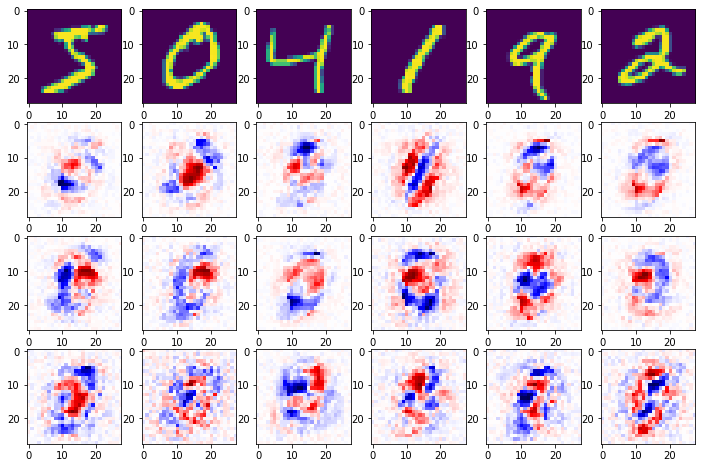

In [ ]:
from tensorflow.keras.models import load_model
# model = load_model('training_mask_2500_images_a=0.6169.h5')
# compare activation similarity
def get_activations(X, model, target_layer, aux_model):
    X = tf.convert_to_tensor(X)
 
    # feed in images and record activations
    print("Retrieving Neuron Activations")
    with tf.GradientTape(persistent=True) as tape:
        # track the input to see how it changes
        tape.watch(X)
        # retrieve output prediction and hidden layer we specified in aux_model
        neuron_activations = aux_model(X)  # eq 1

    neuron_activations = np.array(neuron_activations).reshape(len(X), n_neurons, )

    return neuron_activations

# calc_acc(model, x_test)

# model_normal = get_model()
# optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
# model_normal.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# n = 60000
# model_normal.fit(x_train.reshape(60000, 28, 28, 1), y_train, epochs=1)
# calc_acc(model_normal, x_test.reshape(10000, 28, 28, 1), y_test)
#img = add_noise(img)
batch_size = 1
conv = False
target_layer = len(model.layers)-1 # 9
n_neurons = model.layers[target_layer].output.shape[-1]
# define a model that lets us get at the internal activations
aux_model = tf.keras.Model(inputs=model.inputs,
                            outputs=[model.layers[target_layer].output[:, i] for i in range(n_neurons)])


comp = []
# print('u shape', u.shape)
f, axarr = plt.subplots(4, 6, figsize=(12, 8))
for i in range(6):
  plus = 0
  img = x_train[i+plus:i+plus+1].reshape(1, 28, 28, 1)
  target_neurons = y_train[i+plus:i+plus+1]

  print("pred'", np.argmax(model(img)))
  # img = img.reshape(1, 784)
  with tf.GradientTape(persistent=True) as tape:
    # get predictions and calculate acc loss for the batch
    X = img
    batch_size = 1
    preds = model(X)

    # Get internal activations from aux model
    # x = tf.convert_to_tensor(X, dtype=tf.float32)
    if conv:
      x = tf.reshape(X, (batch_size, 28, 28, 1))
    else:
      x = tf.reshape(X, (batch_size, 28, 28))
    with tf.GradientTape(persistent=True) as aux_tape:
      # this is activations at target_layer
      aux_tape.watch(x)
      neuron_activations = aux_model(x)  # eq 1

    # compute gradients w.r.t from neurons in target layer
    # a bit of wasted computation here as all neuron gradients in the layer are
    # calculated even if we don't use them all...
    grad_maps = []
    for neuron in neuron_activations:
      # local grad maps are (28, 28) images to input
      grad_maps.append(aux_tape.gradient(neuron, x))
    grad_maps = tf.reshape(grad_maps, (batch_size, n_neurons, 784))
    x = tf.reshape(x, (batch_size, 784,))
    neuron_activations = tf.reshape(neuron_activations, (batch_size, n_neurons))

    w_scale_losses = []
    c_scale_losses = []
    dot_losses = []
    joint_losses = []
    # Caclulate v from neuron-input gradients
    for batch in range(batch_size):
      # which output neuron to use
      target_neuron = np.argmax(target_neurons[batch])
      w_hat = tf.reshape(grad_maps[batch][target_neuron], (784,))  # eq 4
      b_hat = tf.math.subtract(neuron_activations[batch][target_neuron], tf.multiply(x[batch], tf.transpose(w_hat)))  # eq 5
      v = tf.math.add(tf.multiply(w_hat, x[batch]), b_hat)  # eq 2
      c_hat = tf.math.subtract(x[batch], tf.tensordot(v / (tf.tensordot(w_hat, tf.transpose(w_hat), axes=1)), w_hat, axes=1))  # CHECK AXES is 1 for both
      v_hat = tf.math.multiply(tf.math.subtract(x[batch], c_hat), w_hat)  # eq 8
      v = tf.transpose(v_hat)

      # we have v = w(x-c)
      # 1. every element component of w and c is between 0 and 1
      w_scale_loss_neg = tf.reduce_sum(tf.abs(tf_relu(w_hat, intercept=tf.constant(0.0), positive=False)))
      w_scale_loss_pos = tf.reduce_sum(tf.abs(tf_relu(w_hat, intercept=tf.constant(1.0), positive=True)))
      w_scale_loss = tf.add(w_scale_loss_neg, w_scale_loss_pos)

      c_scale_loss_neg = tf.reduce_sum(tf.abs(tf_relu(c_hat, intercept=tf.constant(0.0), positive=False)))
      c_scale_loss_pos = tf.reduce_sum(tf.abs(tf_relu(c_hat, intercept=tf.constant(1.0), positive=True)))
      c_scale_loss = tf.add(c_scale_loss_neg, c_scale_loss_pos)
      w_scale_losses.append(w_scale_loss)
      c_scale_losses.append(c_scale_loss)
      # 2. the dot product of w and c is zero.
      dot_loss = tf.tensordot(w_hat, c_hat, axes=1)
      dot_losses.append(dot_loss)
      # 3. w+c = x
      joint_loss = tf.math.subtract(x, tf.math.add(w_hat, c_hat))
      joint_losses.append(joint_loss)
      # acc loss
      # loss = tf.math.reduce_sum(losses) / len(losses) #tf.math.reduce_mean(losses)
      # constraint losses
      w_scale_loss = tf.math.reduce_mean(w_scale_losses)
      c_scale_loss = tf.math.reduce_mean(c_scale_losses)
      dot_loss = tf.math.reduce_mean(dot_losses)
      joint_loss = tf.math.reduce_mean(joint_losses)

  u, s, vh = perform_SVD(img, model, target_layer, aux_model)
  print('U shape before transpose:', u.shape)
  u = u.transpose()
  print('U shape after transpose', u.shape)
  print('s shape', s.shape)
  u = u.transpose()
  # for component in u:
  #   component /=(np.max(np.abs(component)))
  u = u[0]
  u = u.transpose()
  
  w = w_hat.numpy()
  c = c_hat.numpy()
  for component in u:
    component /= np.max(np.abs(component))
  if i == 0:
    comp = u
  axarr[0, i].imshow(img.reshape(28, 28))
  axarr[1, i].imshow(u[0].reshape(28, 28), vmin=-1, vmax=1, cmap='seismic')
  axarr[2, i].imshow(u[1].reshape(28, 28), vmin=-1, vmax=1, cmap='seismic')
  axarr[3, i].imshow(u[2].reshape(28, 28), vmin=-1, vmax=1, cmap='seismic')

  # axarr[2, i].imshow(c_hat.numpy().reshape(28, 28))
  # axarr[3, i].imshow(w_hat.numpy().reshape(28, 28))# single neuron
  # wc = w.reshape(28, 28) * c.reshape(28, 28)
  # wx = w.reshape(28, 28) * x.numpy().reshape(28, 28)
  # axarr[4, i].imshow(wc, vmin=0, vmax=1)#, vmin=-1, vmax=1, cmap='seismic')
  # axarr[5, i].imshow(wx, vmin=0, vmax=1)#, vmin=-1, vmax=1, cmap='seismic')
  # axarr[5, i].imshow(u[3].reshape(28, 28), vmin=-1, vmax=1, cmap='seismic')

  # axarr[i % 8, i // 8].imshow(V[i][0], cmap='seismic') # layer
plt.show()

